In [1]:
import time
import json
import cv2
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from IPython import display
from torch import nn, optim
from PIL import Image
from torch.utils.data import Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Save the train, test data dir in a txt for model-training

In [3]:
train_txt_path = './train.txt'
test_txt_path = './test.txt'
train_1_dir = './train/train_1/'
train_0_dir = './train/train_0/'
test_1_dir = './test/test_1/'
test_0_dir = './test/test_0/'

In [4]:
def gen_txt(txt_path, img1_dir, img0_dir):
    f = open(txt_path, 'w')
    for s_dir in sorted(os.listdir(img1_dir)):
        i_dir = os.path.join(img1_dir, s_dir)
        '''
        if i_dir.split('_')[2] == '0':
            line = i_dir + ' ' + '0' + '\n'
        else:
        '''
        line = i_dir + ' ' + '1' + '\n'
        f.write(line)
    for s_dir in sorted(os.listdir(img0_dir)):
        i_dir = os.path.join(img0_dir, s_dir)
        '''
        if i_dir.split('_')[2] == '0':
            line = i_dir + ' ' + '0' + '\n'
        else:
        '''
        line = i_dir + ' ' + '0' + '\n'
        f.write(line)
        
    f.close()

In [5]:
gen_txt(train_txt_path, train_1_dir, train_0_dir)
gen_txt(test_txt_path, test_1_dir, test_0_dir)

## Load Dataset

In [13]:
class MyDataset(Dataset):
    def __init__(self, txt_path, transform = None, target_transform = None):
        fh = open(txt_path, 'r')
        imgs = []
        for line in fh:
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0], int(words[1])))
            self.imgs = imgs 
            self.transform = transform
            self.target_transform = target_transform

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        #img = Image.open(fn).convert('RGB') 
        img = Image.open(fn)
        #if img.mode != 'L':
            #img = img.convert('L')
        if self.transform is not None:
            img = self.transform(img) 
        return img, label
        
    def __len__(self):
        return len(self.imgs)

## Mean and standard deviations

In [14]:
def getStat(train_data):
    print('Compute mean and variance for training data.')
    print(len(train_data))
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=1, shuffle=False, num_workers=0,
        pin_memory=True)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for X, _ in train_loader:
        for d in range(3):
            mean[d] += X[:, d, :, :].mean()
            std[d] += X[:, d, :, :].std()
    mean.div_(len(train_data))
    std.div_(len(train_data))
    return list(mean.numpy()), list(std.numpy())

In [15]:
train_pipline = torchvision.transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.Resize((227,227)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

valid_pipline = torchvision.transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.Resize((227,227)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_pipline = torchvision.transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.Resize((227,227)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = MyDataset('./train.txt', transform=train_pipline)
valid_data = MyDataset('./test.txt', transform=valid_pipline)
#test_data = MyDataset('./test.txt', transform=test_pipline)


trainloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(dataset=valid_data, batch_size=64, shuffle=True)
#testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)

classes = (0, 1)

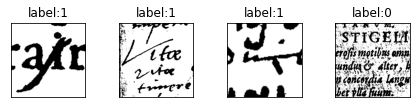

In [16]:
# show some examples of data
examples = enumerate(trainloader)
batch_idx, (example_data, example_label) = next(examples)
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.tight_layout() 
    img = example_data[i]
    img = img.numpy() 
    img = np.transpose(img, (1,2,0)) 
    img = img * [0.5, 0.5, 0.5] + [0.5, 0.5, 0.5]
    plt.imshow(img, 'gray')
    plt.title("label:{}".format(example_label[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

## Model

In [20]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 500),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(500, 20),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(20, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## Setting Hyperparameters

In [21]:
num_classes = 2
num_epochs = 5
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


## Train

In [22]:
total_step = len(trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(1000, 100 * correct / total)) 

    

Epoch [1/5], Step [97/97], Loss: 0.2102
Accuracy of the network on the 1000 validation images: 85.3395061728395 %
Epoch [2/5], Step [97/97], Loss: 0.0715
Accuracy of the network on the 1000 validation images: 89.35185185185185 %
Epoch [3/5], Step [97/97], Loss: 0.0873
Accuracy of the network on the 1000 validation images: 89.04320987654322 %
Epoch [4/5], Step [97/97], Loss: 0.0725
Accuracy of the network on the 1000 validation images: 89.19753086419753 %
Epoch [5/5], Step [97/97], Loss: 0.2451
Accuracy of the network on the 1000 validation images: 90.74074074074075 %


In [25]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(1000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 90.48582995951416 %


In [26]:
# save model
torch.save(model, './new-alexnet-test.pth')

In [28]:
with open ('test_coordinates.json') as f:
    test_coordinates = json.load(f)

## Test on image 194694

In [56]:
model = torch.load('/Users/imchengliang/Downloads/DS-Project/alexnet-test.pth') 
model = model.to(device)
model.eval()

test_data = {}
data_path = '/Users/imchengliang/Downloads/DS-Project/194694/'
for s_dir in sorted(os.listdir(data_path)):
    img = Image.open(data_path+s_dir) 
    if img.mode != 'L':
        img = img.convert('L')

    trans = torchvision.transforms.Compose(
        [
            #torchvision.transforms.Resize((227,227)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    img = trans(img)
    img = img.to(device)
    img = img.unsqueeze(0) 

    classes = ('0', '1')
    output = model(img)
    prob = F.softmax(output, dim=1) 
    print("Probability: ",prob)
    value, predicted = torch.max(output.data, 1)
    predict = output.argmax(dim=1)
    pred_class = classes[predicted.item()]
    print("Prediction: ",pred_class)
    test_data[s_dir.split('.')[0]] = pred_class


1
Probability:  tensor([[0.0356, 0.9644]], grad_fn=<SoftmaxBackward0>)
Prediction:  1
1
Probability:  tensor([[0.9203, 0.0797]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
1
Probability:  tensor([[0.9581, 0.0419]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
1
Probability:  tensor([[0.0047, 0.9953]], grad_fn=<SoftmaxBackward0>)
Prediction:  1
1
Probability:  tensor([[0.7472, 0.2528]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
1
Probability:  tensor([[0.9871, 0.0129]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
1
Probability:  tensor([[0.9983, 0.0017]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
1
Probability:  tensor([[0.9918, 0.0082]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
1
Probability:  tensor([[0.9979, 0.0021]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
1
Probability:  tensor([[0.9890, 0.0110]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
1
Probability:  tensor([[0.9971, 0.0029]], grad_fn=<SoftmaxBackward0>)
Prediction:  0
1
Probability:  tensor([[0.9698, 0.0302]], grad_fn=<So

In [62]:
l = []
for i in test_data.keys():
    if test_data[i] == '1':
        print(i)
        l.append((test_coordinates[i.split('_')[0]][int(i.split('_')[1])]))

194694_10_
194694_235_
194694_557_
194694_6_


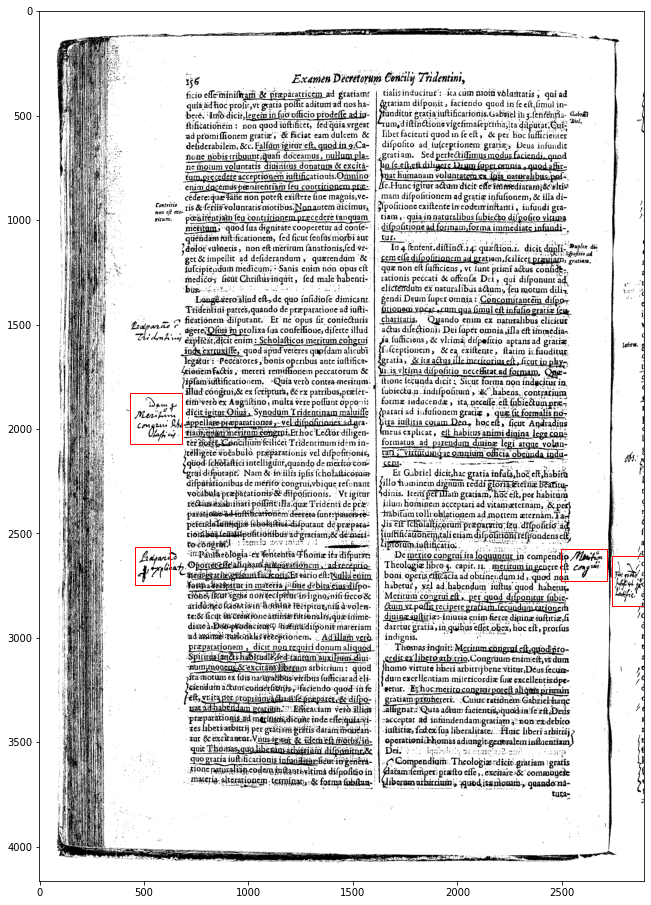

In [65]:
image = cv2.imread('/Users/imchengliang/Downloads/DS-Project/b_w_image/194694.png')
fig, ax = plt.subplots(1, figsize=(18, 16))
ax.imshow(image, cmap='Greys_r')
for i in l:
    rect = patches.Rectangle((i[0], i[1]), i[2], i[3], fill=False, color="r")
    ax.add_patch(rect)
display.display(plt.gcf())
display.clear_output(wait=True)